# **IMPORT LIBRARY**

In [1]:
# Preprocessing Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# Model Imports
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **DATASET**

**Model matematis *plant***:

$$
y(k)= \frac{1}{[1+y(k-1)]^2} + 0,25x(k) - 0,3x(k-1)
$$
</br></nr>
**Info database**:</br>
x(t) = generate random -1 s.d. 1</br>
y(t) = model plant
</br></br>
**Dimensi data**:</br>
30000 $\times$ 2

### **(1). BUAT DATASET**

In [2]:
def plant_data(N):
    # buat nilai x
    np.random.seed(42)
    x_val = np.random.uniform(-1, 1, N)

    # buat nilai y
    y_val = np.zeros(N)
    y_val[0] = 0.0

    for k in range(1, N):
        y_val[k] = 1/(1 + y_val[k-1]**2) + 0.25*x_val[k] - 0.3*x_val[k-1]

    dataset = pd.DataFrame({'x': x_val, 'y': y_val})
    return dataset

# Jumlah data
N = 30004

dk = plant_data(N)
dk

,x,y
0,-0.250920,0.000000
1,0.901429,1.300633
2,0.463988,0.217088
3,0.197317,0.865127
4,-0.687963,0.340751
...,...,...
29999,-0.485204,0.424156
30000,0.276289,1.062157
30001,-0.081415,0.366645
30002,0.928997,1.138175


**visualisasi dataset**

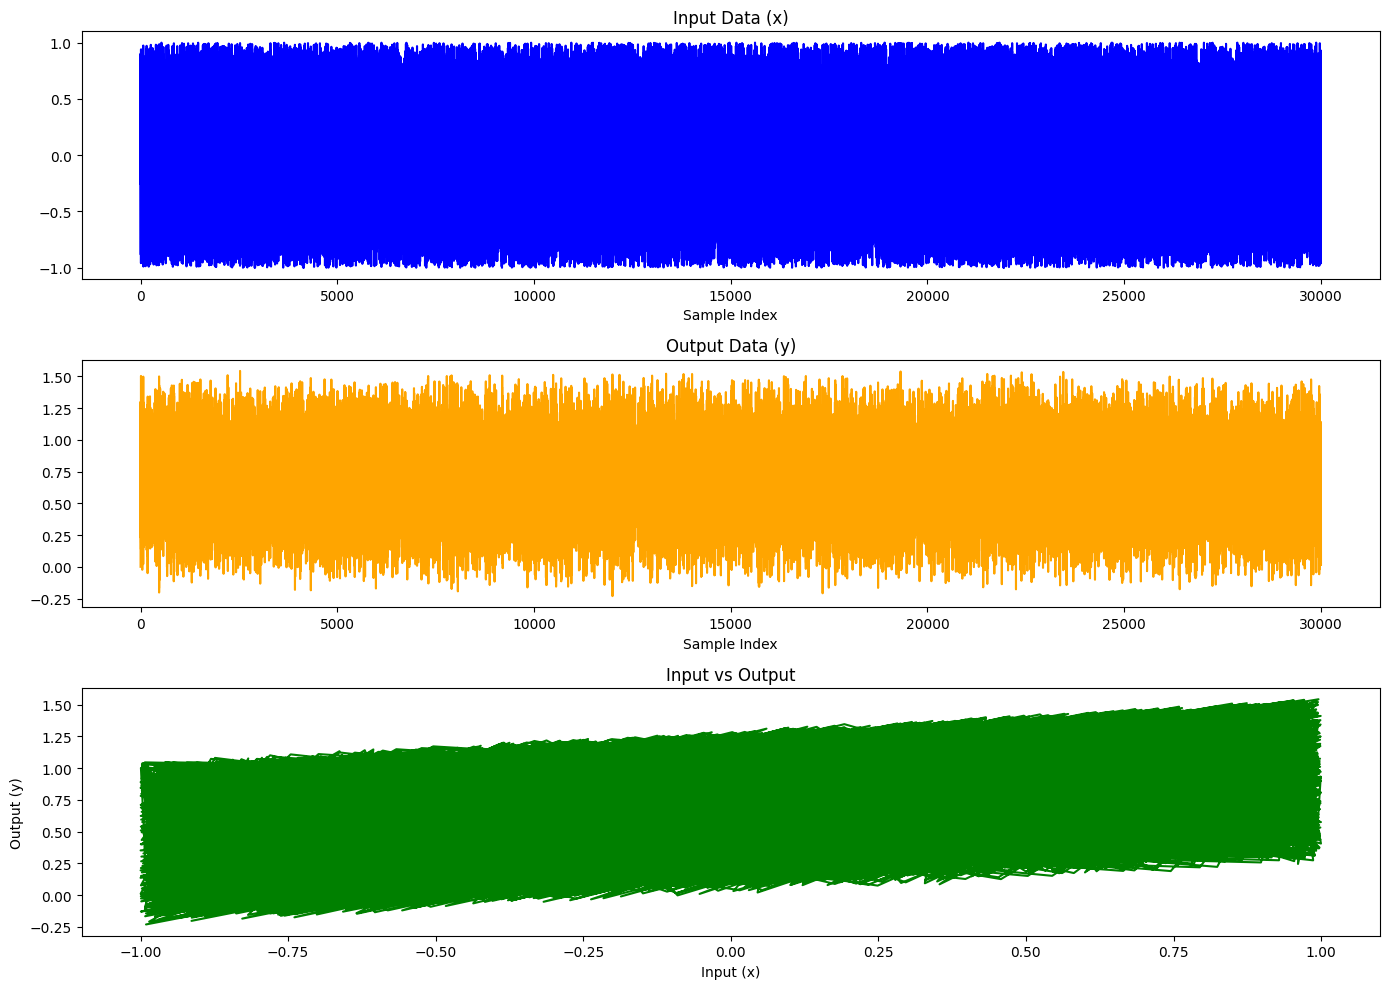

In [5]:
figure, axs = plt.subplots(3, 1, figsize=(14,10))

axs[0].plot(dk['x'], label='Input (x)', color='blue')
axs[0].set_title('Input Data (x)')
axs[0].set_xlabel('Sample Index')

axs[1].plot(dk['y'], label='Output (y)', color='orange')
axs[1].set_title('Output Data (y)')
axs[1].set_xlabel('Sample Index')

axs[2].plot(dk['x'], dk['y'], label='Input (x)', color='green')
axs[2].set_title('Input vs Output')
axs[2].set_xlabel('Input (x)')
axs[2].set_ylabel('Output (y)')

plt.tight_layout()
plt.show()

# **EDA**

### **(1). STRUKTUR DATA**

In [64]:
print("Info Dataset")
print("Ukuran dataset lag:", dk.shape, "\n")
dk.info()

Info Dataset
Ukuran dataset lag: (30004, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30004 entries, 0 to 30003
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       30004 non-null  float64
 1   y       30004 non-null  float64
dtypes: float64(2)
memory usage: 468.9 KB


### **(2). CEK MISSING VALUES**

In [65]:
dk.isna().sum()

x    0
y    0
dtype: int64

**(3). CEK DUPLIKASI**

In [66]:
dk.duplicated().sum()

np.int64(0)

# **PRE-PROCESSING DATA**

### **(1). BUAT MODEL DATA**

In [6]:
def lagged_dataset(df, cols, lag):
    df_new = pd.DataFrame()
    for col in cols:
        for i in range(lag+1):
            if i == 0:
                new_col_name = f'{col}(t)'
            else:
                new_col_name = f'{col}(t-{i})'

            # geser nilai kolom ke bawah sebanyak i
            df_new[new_col_name] = df[col].shift(i)
    
    # drop baris dengan nilai NaN
    df_new = df_new.dropna().reset_index(drop=True)

    return df_new

df_lag = lagged_dataset(dk, cols=['x', 'y'], lag=4)
df_lag

,x(t),x(t-1),x(t-2),x(t-3),x(t-4),y(t),y(t-1),y(t-2),y(t-3),y(t-4)
0,-0.687963,0.197317,0.463988,0.901429,-0.250920,0.340751,0.865127,0.217088,1.300633,0.000000
1,-0.688011,-0.687963,0.197317,0.463988,0.901429,0.930354,0.340751,0.865127,0.217088,1.300633
2,-0.883833,-0.688011,-0.687963,0.197317,0.463988,0.521478,0.930354,0.340751,0.865127,0.217088
3,0.732352,-0.883833,-0.688011,-0.687963,0.197317,1.234439,0.521478,0.930354,0.340751,0.865127
4,0.202230,0.732352,-0.883833,-0.688011,-0.687963,0.227073,1.234439,0.521478,0.930354,0.340751
...,...,...,...,...,...,...,...,...,...,...
29995,-0.485204,-0.197990,-0.961088,0.495648,0.904551,0.424156,1.028279,0.516434,0.323239,1.060438
29996,0.276289,-0.485204,-0.197990,-0.961088,0.495648,1.062157,0.424156,1.028279,0.516434,0.323239
29997,-0.081415,0.276289,-0.485204,-0.197990,-0.961088,0.366645,1.062157,0.424156,1.028279,0.516434
29998,0.928997,-0.081415,0.276289,-0.485204,-0.197990,1.138175,0.366645,1.062157,0.424156,1.028279


### **(2). SPLIT DATA INPUT DAN TARGET**

In [7]:
X1 = df_lag[['x(t)', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'x(t-4)', 'y(t-1)', 'y(t-2)', 'y(t-3)', 'y(t-4)']].values
Y1 = df_lag[['y(t)']].values

print("Input (X) set shape :", X1.shape)
print("Target (Y) set shape:", Y1.shape)

Input (X) set shape : (30000, 9)
Target (Y) set shape: (30000, 1)


### **(3). SPLIT MODEL DATASET**

X = [X(t), X(t-1), X(t-2), X(t-3), X(t-4), Y(t-1), Y(t-2), Y(t-3), Y(t-4)]</br>
Y = [Y(t)]</br>

**Training** : 15000 dataset</br>
**Validasi** : 10000 (5000 data training akhir + 5000 dataset)</br>
**Testing**  : 10000 dataset

In [8]:
def split_dataset(X, Y):
    assert len(X) == len(Y), "Panjang X dan Y harus sama"
    assert len(X) == 30000,  "Dataset harus 30.000 sample sesuai aturan"

    X_train = X[:15000]
    Y_train = Y[:15000]

    X_val = np.concatenate([X_train[-5000:], X[15000:20000]])
    Y_val = np.concatenate([Y_train[-5000:], Y[15000:20000]])

    X_test = X[20000:]
    Y_test = Y[20000:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X1_train, Y1_train, X1_val, Y1_val, X1_test, Y1_test = split_dataset(X1, Y1)

print("Train shape  :", X1_train.shape, Y1_train.shape)
print("Val shape    :", X1_val.shape, Y1_val.shape)
print("Test shape   :", X1_test.shape, Y1_test.shape)

Train shape  : (15000, 9) (15000, 1)
Val shape    : (10000, 9) (10000, 1)
Test shape   : (10000, 9) (10000, 1)


**Visualisasi Dataset**

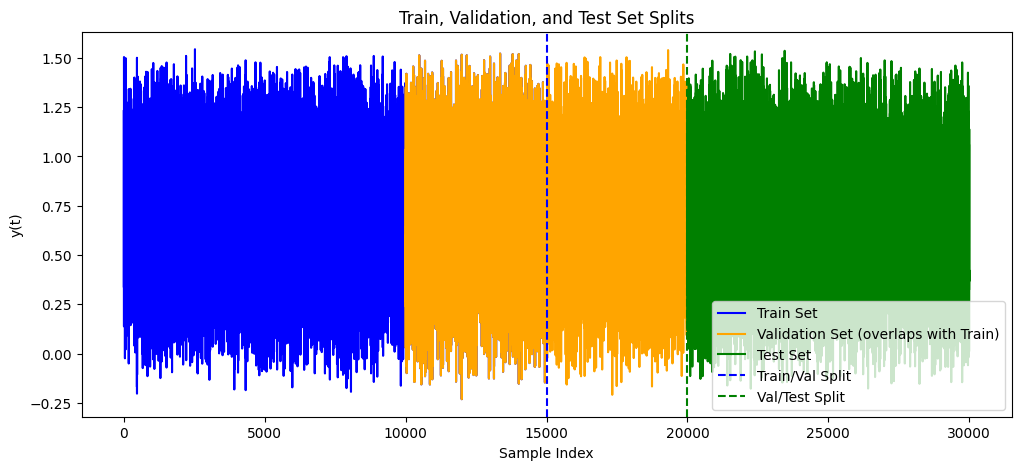

In [9]:
plt.figure(figsize=(12, 5))

# Define index ranges
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = (test_start + len(Y1_test))

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), Y1_train, label='Train Set', color='blue')
plt.plot(range(val_start, val_end), Y1_val, label='Validation Set (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), Y1_test, label='Test Set', color='green')

# Add vertical lines to indicate splits
plt.axvline(x=train_end, color='blue', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end, color='green', linestyle='--', label='Val/Test Split')

plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('y(t)')
plt.title('Train, Validation, and Test Set Splits')
plt.show()

### **(3). NORMALISASI DATASET**

In [93]:
# --- NORMALISASI (-1, 1) ---
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

# Fit training data
X1_train_norm = scaler_X.fit_transform(X1_train)
Y1_train_norm = scaler_Y.fit_transform(Y1_train)

# Transform validation and testing data
X1_val_norm = scaler_X.transform(X1_val)
Y1_val_norm = scaler_Y.transform(Y1_val)

X1_test_norm = scaler_X.transform(X1_test)
Y1_test_norm = scaler_Y.transform(Y1_test)

# --- CEK HASIL ---
print("Scaled Training  : ", X1_train_norm.shape, Y1_train_norm.shape)
print("Scaled Validation: ", X1_val_norm.shape, Y1_val_norm.shape)
print("Scaled Testing   : ", X1_test_norm.shape, Y1_test_norm.shape)

Scaled Training  :  (15000, 9) (15000, 1)
Scaled Validation:  (10000, 9) (10000, 1)
Scaled Testing   :  (10000, 9) (10000, 1)


**Visualisasi Dataset Normalisasi**

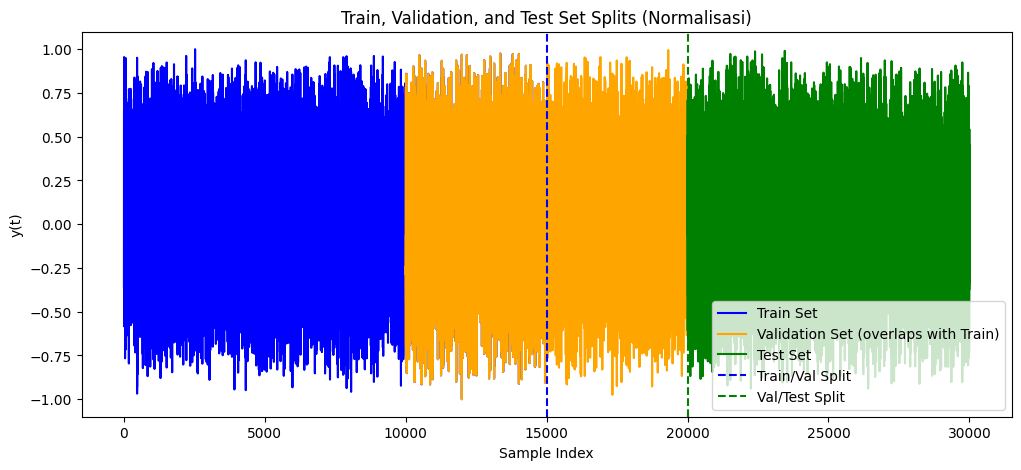

In [72]:
plt.figure(figsize=(12, 5))

# Define index ranges
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = (test_start + len(Y1_test_norm))

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), Y1_train_norm, label='Train Set', color='blue')
plt.plot(range(val_start, val_end), Y1_val_norm, label='Validation Set (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), Y1_test_norm, label='Test Set', color='green')

# Add vertical lines to indicate splits
plt.axvline(x=train_end, color='blue', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end, color='green', linestyle='--', label='Val/Test Split')

plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('y(t)')
plt.title('Train, Validation, and Test Set Splits (Normalisasi)')
plt.show()

# **SISTEM IDENTIFIKASI (PLANT)**

## **STAGE 1**

### **(1). BUAT MODEL MLP**

In [94]:
# MLP Model
def build_stage1(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(output_dim))
    model.compile(loss='mean_squared_error')
    return model

input1_dim = X1_train_norm.shape[1]
output1_dim = Y1_train_norm.shape[1]

model_stage1 = build_stage1(input1_dim, output1_dim)
model_stage1.summary()

c:\Users\Hanna\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 865 (3.38 KB)

 Trainable params: 865 (3.38 KB)

 Non-trainable params: 0 (0.00 B)

### **(2). TRAINING-VALIDATION**

In [95]:
# Path to save best weight + model
best_weightsPath = "bestWeights1.keras"

# Checkpoint to monitor errors
checkpoint = ModelCheckpoint(best_weightsPath, 
                             monitor='val_loss', # Monitor validation loss
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

# For early stopping
early_stopping_criteria = EarlyStopping(patience=15)

# List for callbacks
callbacks_list = [checkpoint, early_stopping_criteria]

# Training
history = model_stage1.fit(X1_train_norm, Y1_train_norm, 
                    epochs = 1000,
                    validation_data = (X1_val_norm, Y1_val_norm),
                    callbacks=callbacks_list)

model_stage1.save('final_model1.keras')

Epoch 1/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0111 - val_loss: 7.8940e-04
Epoch 2/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9607e-04 - val_loss: 3.7873e-04
Epoch 3/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9524e-04 - val_loss: 4.9596e-04
Epoch 4/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9676e-04 - val_loss: 1.9112e-04
Epoch 5/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3573e-04 - val_loss: 5.5171e-04
Epoch 6/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0275e-04 - val_loss: 8.3661e-05
Epoch 7/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7762e-04 - val_loss: 1.0937e-04
Epoch 8/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6812e-04 - val_loss: 2.3433e-04
Epoch 9/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4785e-04 - val_loss: 2.2764e-04
Epoch 10/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4396e-04 - val_loss: 1.3278e-04
Epoch 11/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 

**Plot Loss Train vs Val**

In [96]:
def get_model_info(model):
    layer_info = []
    
    for layer in model.layers:
        cfg = layer.get_config()
        name = layer.name
        activation = cfg.get("activation", "None")
        units = cfg.get("units", None)

        if units is not None:  # Hanya untuk Dense layer
            layer_info.append(f"{name}: units={units}, activation={activation}")
    
    # Untuk dijadikan nama file pendek: hanya hidden + aktivasi utama
    hidden_layers = [cfg.get("units") for cfg in (l.get_config() for l in model.layers) if cfg.get("units")]

    activations = [cfg.get("activation") for cfg in (l.get_config() for l in model.layers) if cfg.get("activation")]

    return layer_info, hidden_layers, activations


# Get model information
layer_info, hidden_layers, activations = get_model_info(model_stage1)

print("Layer Info:")
for info in layer_info:
    print(info)


Layer Info:
dense_15: units=32, activation=relu
dense_16: units=16, activation=relu
dense_17: units=1, activation=linear


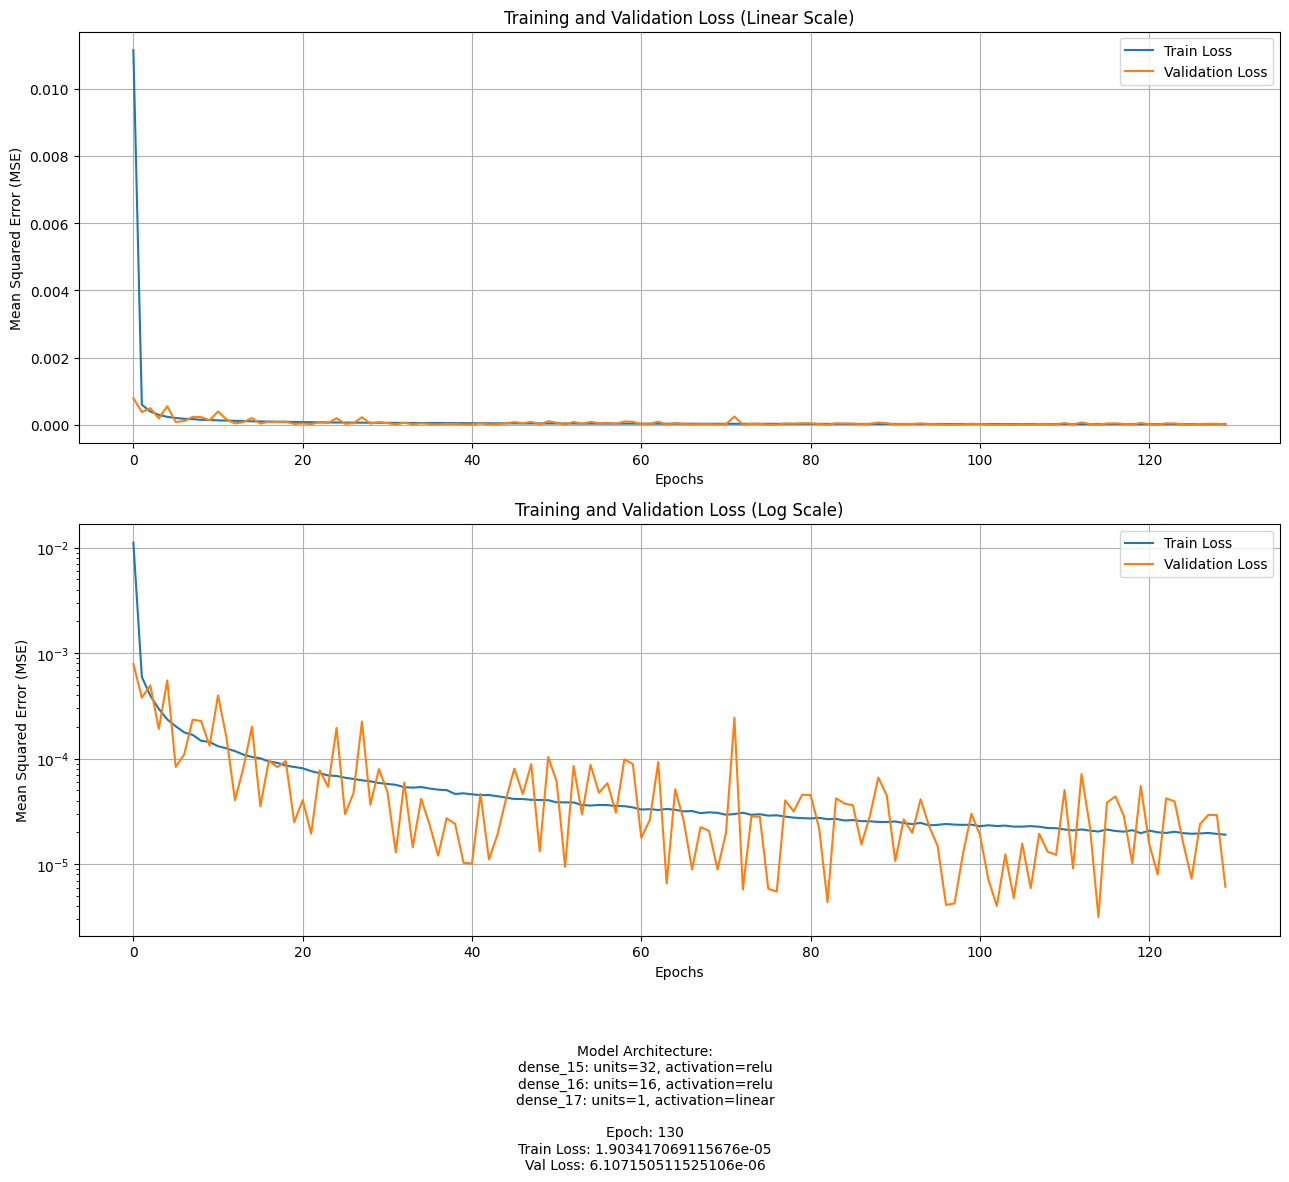

In [98]:
# info plot
train_losses = history.history["loss"]
val_losses = history.history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]

annotation_text = annotation_text = (
    "Model Architecture:\n" +
    "\n".join(layer_info) +
    f"\n\nEpoch: {last_epoch}"
    f"\nTrain Loss: {train_error}"
    f"\nVal Loss: {val_error}"
)

# plotting
fig, ax = plt.subplots(2, 1, figsize=(13, 10))

# ====== linear scale plot =====
ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_title('Training and Validation Loss (Linear Scale)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].legend()
ax[0].grid(True)

# ===== log scale plot =====
ax[1].semilogy(train_losses, label='Train Loss')
ax[1].semilogy(val_losses, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean Squared Error (MSE)')
ax[1].set_title('Training and Validation Loss (Log Scale)')
ax[1].grid(True)
ax[1].legend()

fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

### **(3). TESTING**

**MSE TEST**

**Komparasi nilai aktual dan prediksi**

In [101]:
# prediksi train dan val set
y_pred_train_norm = model_stage1.predict(X1_train_norm)
y_pred_train = scaler_Y.inverse_transform(y_pred_train_norm)
y_actual_train = Y1_train

y_pred_val_norm = model_stage1.predict(X1_val_norm)
y_pred_val = scaler_Y.inverse_transform(y_pred_val_norm)
y_actual_val = Y1_val

# ======= prediksi test set ======
y_pred_test_norm = model_stage1.predict(X1_test_norm)
y_pred_test = scaler_Y.inverse_transform(y_pred_test_norm)
y_actual_test = Y1_test

df_compare = pd.DataFrame({
    'Actual Y': y_actual_test.flatten(),
    'Predicted Y': y_pred_test.flatten(),
    'MSE': (y_actual_test - y_pred_test).flatten()**2
})

df_compare

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


,Actual Y,Predicted Y,MSE
0,0.604149,0.602566,2.507262e-06
1,0.862634,0.863354,5.182030e-07
2,0.660810,0.661291,2.308231e-07
3,0.227602,0.223417,1.751926e-05
4,1.285604,1.284459,1.312045e-06
...,...,...,...
9995,0.424156,0.423655,2.509111e-07
9996,1.062157,1.063085,8.620883e-07
9997,0.366645,0.364725,3.685303e-06
9998,1.138175,1.137079,1.201750e-06


**Visualisasi Prediksi-Aktual Output**

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5.9541e-06


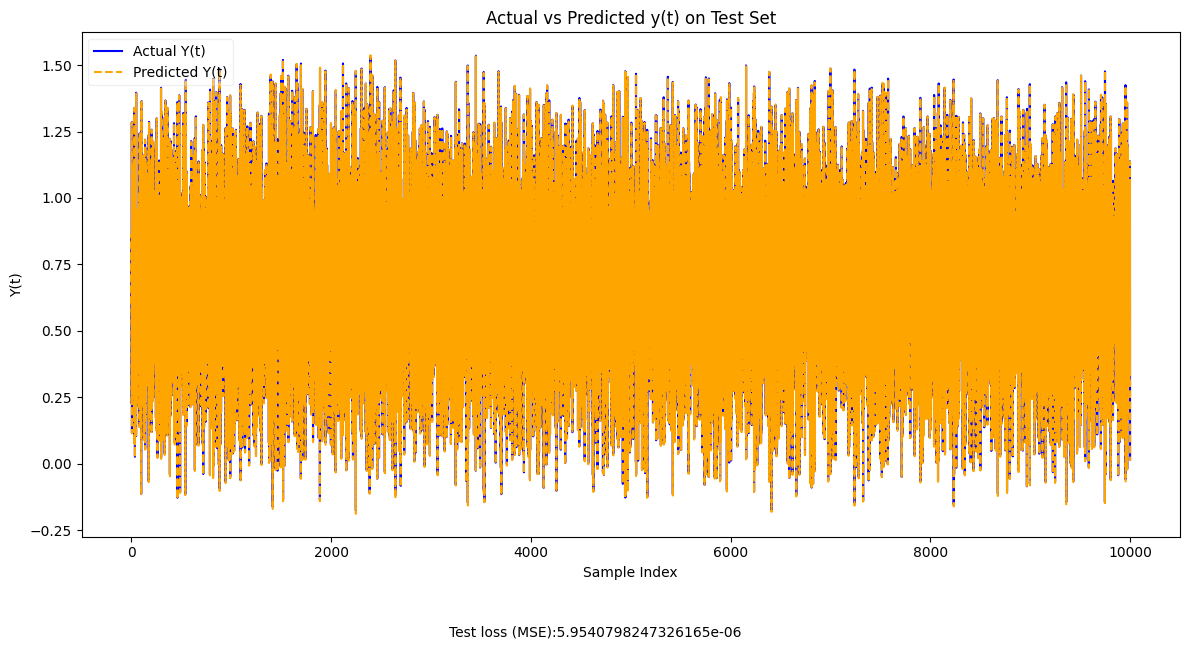

In [102]:
test_loss = model_stage1.evaluate(X1_test_norm, Y1_test_norm)

# plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_actual_test, label='Actual Y(t)', color='blue')
ax.plot(y_pred_test, label='Predicted Y(t)', color='orange', linestyle='--') 
ax.set_title('Actual vs Predicted y(t) on Test Set')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Y(t)')
ax.legend(framealpha=0.3)
fig.text(0.5, -0.05, 
         f"Test loss (MSE):" + str(test_loss),
         ha='center', va='top')

plt.tight_layout()
plt.show()

## **STAGE 2**

### **(1). DATA**

In [103]:
# Load model stage 1
model_stage1 = load_model('final_model1.keras')

n_samples = len(df_lag)

X1_all = df_lag[['x(t)', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'x(t-4)',
                'y(t-1)', 'y(t-2)', 'y(t-3)', 'y(t-4)']].values
X1_all_norm = scaler_X.transform(X1_all)

y_pred_all_norm = model_stage1.predict(X1_all_norm, verbose=0)
y_pred_all = scaler_Y.inverse_transform(y_pred_all_norm)

# simpa ke df_lag untuk lag prediksi
df_lag['y_pred(t)'] = y_pred_all
df_lag['y_pred(t-1)'] = df_lag['y_pred(t)'].shift(1)
df_lag['y_pred(t-2)'] = df_lag['y_pred(t)'].shift(2)
df_lag['y_pred(t-3)'] = df_lag['y_pred(t)'].shift(3)
df_lag['y_pred(t-4)'] = df_lag['y_pred(t)'].shift(4)
df2 = df_lag.dropna().reset_index(drop=True)

# data untuk stage 2
X2 = df2[['x(t)', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'x(t-4)',
          'y_pred(t-1)', 'y_pred(t-2)', 'y_pred(t-3)', 'y_pred(t-4)']].values
Y2 = df2[['y(t)']].values

print("Input (X) set shape :", X2.shape)
print("Target (Y) set shape:", Y2.shape)

Input (X) set shape : (29996, 9)
Target (Y) set shape: (29996, 1)


### **(2). SPLIT DATA**

In [104]:
N = len(X2)

X2_train = X2[:15000]
Y2_train = Y2[:15000]

X2_val = X2[15000:20000]
Y2_val = Y2[15000:20000]

X2_test = X2[20000:]
Y2_test = Y2[20000:]


print("Train shape  :", X2_train.shape, Y2_train.shape)
print("Val shape    :", X2_val.shape, Y2_val.shape)
print("Test shape   :", X2_test.shape, Y2_test.shape)


Train shape  : (15000, 9) (15000, 1)
Val shape    : (5000, 9) (5000, 1)
Test shape   : (9996, 9) (9996, 1)


### **(3). NORMALISASI**

In [ ]:
scaler_X2 = scaler_X      # boleh pakai scaler-X sama seperti stage1
scaler_Y2 = scaler_Y      # atau buat baru, terserah Anda

X2_train_norm = scaler_X2.fit_transform(X2_train)
X2_val_norm   = scaler_X2.transform(X2_val)
X2_test_norm  = scaler_X2.transform(X2_test)

Y2_train_norm = scaler_Y2.fit_transform(Y2_train)
Y2_val_norm   = scaler_Y2.transform(Y2_val)
Y2_test_norm  = scaler_Y2.transform(Y2_test)

X2_train_norm = X2_train_norm.astype('float32')
Y2_train_norm = Y2_train_norm.astype('float32')

X2_val_norm = X2_val_norm.astype('float32')
Y2_val_norm = Y2_val_norm.astype('float32')

X2_test_norm = X2_test_norm.astype('float32')
Y2_test_norm = Y2_test_norm.astype('float32')


print("Scaled Training  : ", X2_train_norm.shape, Y2_train_norm.shape)
print("Scaled Validation: ", X2_val_norm.shape, Y2_val_norm.shape)
print("Scaled Testing   : ", X2_test_norm.shape, Y2_test_norm.shape)

Scaled Training  :  (15000, 9) (15000, 1)
Scaled Validation:  (5000, 9) (5000, 1)
Scaled Testing   :  (9996, 9) (9996, 1)


### **(4). MODEL MLP STAGE 2**

In [106]:
def build_stage2(input_dim):
    model = Sequential()
    model.add(tf.keras.Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error')
    return model

model2 = build_stage2(X2_train_norm.shape[1])
optimizer = tf.keras.optimizers.Adam(1e-3)

### **(5). TRAINING-VALIDATION (CUSTOM LOOP)**

In [ ]:
# ============ Training Step ==============
@tf.function
def train_step(xi, yi):
    with tf.GradientTape() as tape:
        y_pred = model2(xi, training=True)
        loss = tf.reduce_mean((yi - y_pred)**2)
    grads = tape.gradient(loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(grads, model2.trainable_variables))
    return loss


# ============ Training Loop ==============
train_losses = []
val_losses = []

epochs = 100

for epoch in range(epochs):
    # ==== TRAINING PER-SAMPLE ====
    epoch_loss = 0.0
    for i in range(len(X2_train_norm)):
        xi = X2_train_norm[i:i+1]
        yi = Y2_train_norm[i:i+1]
        loss = train_step(xi, yi)
        epoch_loss += loss.numpy()

    epoch_loss /= len(X2_train_norm)
    train_losses.append(epoch_loss)

    # ==== VALIDATION ====
    y_val_pred = model2.predict(X2_val_norm, verbose=0)
    val_loss = np.mean((Y2_val_norm - y_val_pred)**2)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}  TrainLoss={epoch_loss}  ValLoss={val_loss}")


Epoch 1/100  TrainLoss=0.001628  ValLoss=0.000194
Epoch 2/100  TrainLoss=0.000140  ValLoss=0.000067
Epoch 3/100  TrainLoss=0.000092  ValLoss=0.000069
Epoch 4/100  TrainLoss=0.000071  ValLoss=0.000034
Epoch 5/100  TrainLoss=0.000058  ValLoss=0.000017
Epoch 6/100  TrainLoss=0.000053  ValLoss=0.000013
Epoch 7/100  TrainLoss=0.000048  ValLoss=0.000042
Epoch 8/100  TrainLoss=0.000046  ValLoss=0.000018
Epoch 9/100  TrainLoss=0.000044  ValLoss=0.000015
Epoch 10/100  TrainLoss=0.000039  ValLoss=0.000029
Epoch 11/100  TrainLoss=0.000038  ValLoss=0.000023
Epoch 12/100  TrainLoss=0.000037  ValLoss=0.000015
Epoch 13/100  TrainLoss=0.000033  ValLoss=0.000023
Epoch 14/100  TrainLoss=0.000033  ValLoss=0.000011
Epoch 15/100  TrainLoss=0.000033  ValLoss=0.000021
Epoch 16/100  TrainLoss=0.000032  ValLoss=0.000010
Epoch 17/100  TrainLoss=0.000032  ValLoss=0.000021
Epoch 18/100  TrainLoss=0.000030  ValLoss=0.000009
Epoch 19/100  TrainLoss=0.000032  ValLoss=0.000008
Epoch 20/100  TrainLoss=0.000030  ValLos

**plot loss train dan val**

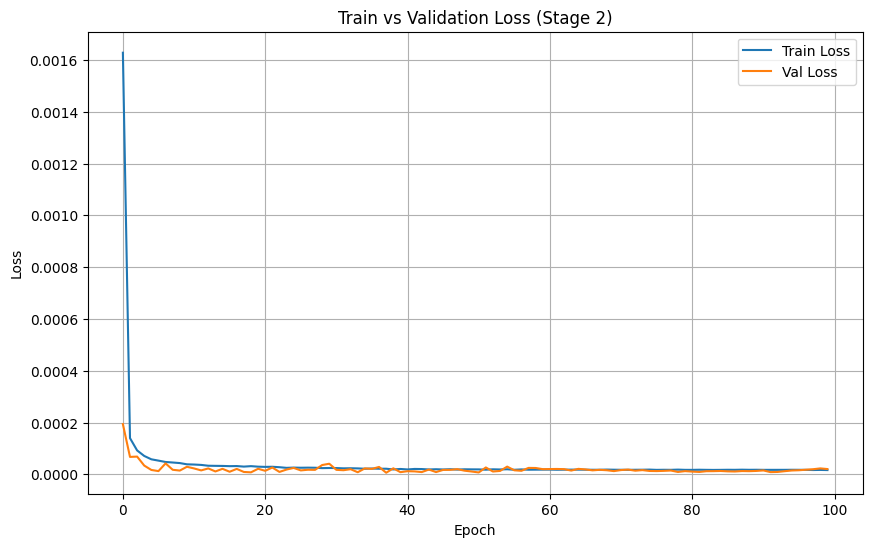

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (Stage 2)')
plt.legend()
plt.grid(True)
plt.show()

### **(6). TESTING**

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


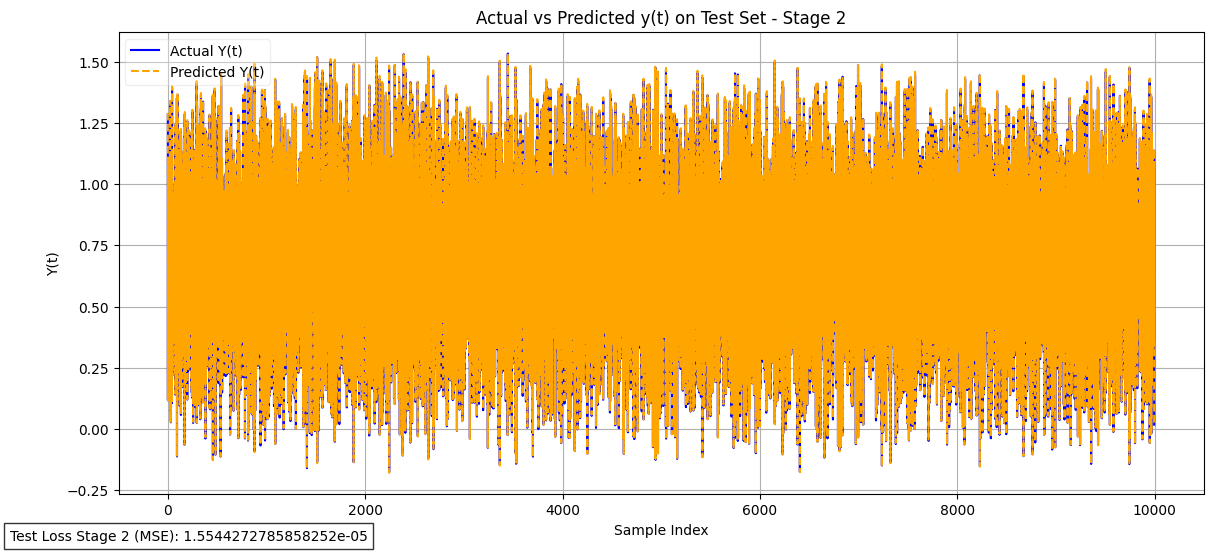

In [110]:
y2_test_pred_norm = model2.predict(X2_test_norm)
y2_test_pred = scaler_Y2.inverse_transform(y2_test_pred_norm)
y2_test_actual = Y2_test

test_loss2 = np.mean((Y2_test - y2_test_pred)**2)

# plotting
plt.figure(figsize=(14, 6))
plt.plot(y2_test_actual, label='Actual Y(t)', color='blue')
plt.plot(y2_test_pred, label='Predicted Y(t)', color='orange', linestyle='--')
plt.title('Actual vs Predicted y(t) on Test Set - Stage 2')
plt.xlabel('Sample Index')
plt.ylabel('Y(t)')
plt.legend(framealpha=0.3)
plt.text(
    -0.10, -0.10,             # posisi relatif plot
    f"Test Loss Stage 2 (MSE): {test_loss2}",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.grid(True)
plt.show()